# Project: Cluj-Napoca Apartment Sales Data Analysis
**Author:** Priala Radu-Nicușor

**Date:** 07/03/2024

## Overview
This project involves web scraping data from a local apartment sales website and performing data analysis on the extracted information. The goal is to gain insights into the real estate market, understand pricing trends, and make informed decisions based on the analyzed data.

## Libraries Used
- **pandas:** Data manipulation and analysis
- **numpy:** Numerical operations
- **matplotlib:** Data visualization
- **re:** Regular expressions for text processing
- **requests:** HTTP requests for web scraping
- **BeautifulSoup:** HTML parsing for web scraping

# Table of Contents

1. [Web Scraping and Retrieving Data](#web-scraping-and-retrieving-data)
2. [Cleaning and Parsing the Data](#cleaning-and-parsing-the-data)
3. [Statistical Analysis (NumPy)](#statistical-analysis-numpy)
4. [Statistical Visualization (Matplotlib)](#statistical-visualization-matplotlib)

We start by importing necessary libraries

In [1]:
# Importing libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing libraries for web scraping
import re
import requests
from bs4 import BeautifulSoup

## 1. Web Scraping and Retrieving Data <a id='web-scraping-and-retrieving-data'></a>

In [4]:
# Setting user agent header for the HTTP request
headers = {'User-Agent': 'Chrome/91.0.4472.124'}

# Function to retrieve the total number of pages for apartment listings
def get_number_of_pages():
    url = 'https://www.storia.ro/ro/rezultate/vanzare/apartament/cluj/cluj--napoca?viewType=listing'
    # To create a request and to parse HTML content
    response = requests.get(url, headers=headers)
    html_content = response.text
    soup = BeautifulSoup(html_content, 'html.parser')
    # To find and retrieve the value of the last page
    page_buttons = soup.find_all('li', class_='css-1tospdx')
    return int(page_buttons[-1].text)

# Function to retrieve apartment listing URLs
def retrieve_listing_urls(pages_to_scrape):
    all_urls = []
    print("Pages read till now: ")
    for page in range(1, pages_to_scrape + 1):
        url = f'https://www.storia.ro/ro/rezultate/vanzare/apartament/cluj/cluj--napoca?viewType=listing&page={page}'
        # To create a request and to parse HTML content
        response = requests.get(url, headers=headers)
        html_content = response.text
        soup = BeautifulSoup(html_content, 'html.parser')
        # To retrieve all listing urls and to convert them to usable format
        try:
            listings_container = soup.select_one('div[data-cy="search.listing.organic"]')
            urls = listings_container.find_all('a', class_="css-16vl3c1 e1njvixn0")
            for url in urls:
                all_urls.append('https://www.storia.ro' + url['href'])
        except AttributeError:
            print(f"Warning: Invalid listing at page {page}")
        print(page, end=' ')    
    return all_urls

We are going to retrieve the number of pages and store all listing urls that we found throughout all pages.

In [3]:
total_pages = get_number_of_pages()    
all_listing_urls = retrieve_listing_urls(total_pages)

# Also, let's see the number of pages and the first few listing urls
print(f"The total amount of pages: {total_pages}")
print(all_listing_urls[:10])

Pages read till now: 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 The total amount of pages: 220
['https://www.storia.ro/ro/oferta/pf-vand-apartament-2-camere-gheorgheni-IDzvxl', 'https://www.storia.ro/ro/oferta/de-la-dezvoltator-apartamente-cu-2-camere-zona-bmw-proiect-n

We will store all the listings urls in a text file.

In [7]:
file_path = 'listings_urls.txt'

with open(file_path, 'w') as file:
    for url in all_listing_urls:
        file.write(url + '\n')
        
print("All urls were saved in listings_urls.txt")
print(f"Total number of apartment listings: {len(all_listing_urls)}")

All urls were saved in listings_urls.txt
Total number of apartment listings: 7906


Then, we will create a function that will read all the available details for an apartment listing, and another function that will retrieve the details for every listing.

In [13]:
def get_all_listings_details(urls):
    all_listings = []
    count = 1
    for url in urls:
        count += 1
        details = retrieve_listing_details(url);
        all_listings.append(details)
        if count % 25 == 0:
            print(f"{count}+ ", end='')
        if count == 300:
            break
    return all_listings    
        

def retrieve_listing_details(url):
    resp = requests.get(url, headers=headers)
    html_content = resp.text
    soup = BeautifulSoup(html_content, 'html.parser')
    
    data = dict()
    # To retrieve every detail present in 'details information'
    try:
        container = soup.find_all('div', class_='css-1wi2w6s enb64yk5')
        pattern_keys = re.compile(r'table-value-(\w+)')
        for detail in container:
            if 'data-testid' in str(detail):
                key = detail['data-testid']
                key = pattern_keys.search(key).group(1)
                value = detail.get_text(strip=True)
                data.update({key: value})
    except ValueError:
        print("Invalid url", end=', ')
    # To retrieve adress information (from header)
    try: 
        adress = soup.find('a', class_='e1w8sadu0 css-nqd0ku exgq9l20')
        adress = adress.text
        data.update({'adress': adress})
    except AttributeError:
        print("Adress not found", end=', ')
    # To retrieve price information (from header)
    try:
        price = soup.find('strong', class_='css-t3wmkv e1l1avn10')
        price = price.text
        data.update({'price': price})
    except AttributeError:
        print("Price not found", end=', ')     
        
    return data

print("Listings read: ", end='')
data = get_all_listings_details(all_listing_urls)
print("All available listings were read!")

Listings read: 25+ 50+ 75+ 100+ 125+ 150+ 175+ 200+ 225+ 250+ 275+ 300+ All available listings were read!


Now, we have our data represented as a list of dictionaries, where every dictionary represents an apartment listing, the keys represent the detail name and the values represent the detail value.

Next, we are going to retrieve all unique keys present in our data, so we can create a DataFrame for all listings.

In [14]:
# All unique keys
all_keys = list(set(key for d in data for key in d.keys()))
all_keys = sorted(all_keys)
print(all_keys)

# To create a DataFrame with column labels equal to our unique keys
df = pd.DataFrame(columns=all_keys)

# To add every single listing into our DataFrame
df = pd.DataFrame([listing for listing in data])
print("DataFrame created successfully.")

['adress', 'advertiser_type', 'area', 'build_year', 'building_material', 'building_ownership', 'building_type', 'car', 'construction_status', 'equipment_types', 'extras_types', 'floor', 'heating', 'lift', 'market', 'media_types', 'outdoor', 'price', 'rent', 'rooms_num', 'security_types', 'windows_type']
DataFrame created successfully.


Our DataFrame was created. We will save the uncleaned DataFrame into a txt file.

In [15]:
df.to_csv('uncleaned_data.txt', sep=',', index=False)
print("DataFrame saved to 'uncleaned_data.csv'.")

DataFrame saved to 'uncleaned_data.csv'.


Our DataFrame was created. We can check important information about our data

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   area                 299 non-null    object
 1   rooms_num            299 non-null    object
 2   market               299 non-null    object
 3   advertiser_type      299 non-null    object
 4   lift                 299 non-null    object
 5   adress               299 non-null    object
 6   price                299 non-null    object
 7   building_ownership   14 non-null     object
 8   construction_status  120 non-null    object
 9   floor                294 non-null    object
 10  outdoor              154 non-null    object
 11  car                  7 non-null      object
 12  heating              137 non-null    object
 13  build_year           198 non-null    object
 14  building_type        34 non-null     object
 15  windows_type         19 non-null     object
 16  media_ty

## 2. Cleaning and Parsing the Data <a id='cleaning-and-parsing-the-data'></a>

We will go through each column and decide if it contains important data, if not, we can delete the column. 

We will check if the column needs any parsing. For example, column 'area' can be converted from format <area m²> to < area > (float). Also, column 'price' can be converted from format <price €> to < price > (float).

In [17]:
sorted(df.columns)

['adress',
 'advertiser_type',
 'area',
 'build_year',
 'building_material',
 'building_ownership',
 'building_type',
 'car',
 'construction_status',
 'equipment_types',
 'extras_types',
 'floor',
 'heating',
 'lift',
 'market',
 'media_types',
 'outdoor',
 'price',
 'rent',
 'rooms_num',
 'security_types',
 'windows_type']

Checking/Parsing/Modifying column 'adress'

In [18]:
df['adress'].unique()[:5]

array(['Marasti, Cluj-Napoca, Cluj', 'Strada Avram Iancu, Floresti, Cluj',
       'Centru, Cluj-Napoca, Cluj', 'Buna Ziua, Cluj-Napoca, Cluj',
       'Manastur, Cluj-Napoca, Cluj'], dtype=object)

In [19]:
# We can split the adress into two individual columns: street and neighbourhood

def retrieve_street(address):
    try:
        address = [part.strip() for part in address.split(',')]
        if len(address) == 4 and (address[2] == 'Cluj-Napoca'):
            return address[0]
    except Exception as e:
        print(f"Error in retrieve_street: {e}")
    return None

def retrieve_neighbourhood(address):
    try:
        address = [part.strip() for part in address.split(',')]
        if len(address) == 3 and (address[1] == 'Cluj-Napoca'):
            return address[0]
        elif len(address) == 4 and (address[2] == 'Cluj-Napoca'):
            return address[1]
    except Exception as e:
        print(f"Error in retrieve_neighbourhood: {e}")
    return None

    
# To create two new columns: street and neighbourhood    
df['street'] = df['adress'].apply(retrieve_street)
df['neighbourhood'] = df['adress'].apply(retrieve_neighbourhood)    
    
# To delete the adress column    
df = df.drop('adress', axis=1)   

In [20]:
print(df['street'].unique()[:5])
print(df['neighbourhood'].unique()[:5])

[None 'Bulevardul Muncii' 'Strada Almasului' 'Strada Mircea Eliade'
 'Strada Tasnad']
['Marasti' None 'Centru' 'Buna Ziua' 'Manastur']


Checking/Parsing/Modifying column 'advertiser_type'

In [21]:
df['advertiser_type'].unique()
# This column doesn't require any modification

array(['agenție', 'privat'], dtype=object)

Checking/Parsing/Modifying column 'area'

In [22]:
df['area'].unique()[:10]

array(['46 m²', '57 m²', '80 m²', '78 m²', '75 m²', '42,36 m²', '50 m²',
       '68 m²', '53 m²', '56,8 m²'], dtype=object)

In [23]:
# We will create a function that will parse our 'area' values

def convert_area_values(area):
    if type(area) == str:
        area = area.replace(',', '.')
        return int(float(area.replace(' m²', '').replace(' ', '')))
    else:
        return area

df['area'] = df['area'].apply(convert_area_values)
df['area'] = df['area'].fillna(0).astype(int)
df['area'].unique()[:10]

array([46, 57, 80, 78, 75, 42, 50, 68, 53, 56])

Checking/Parsing/Modifying column 'build_year'

In [24]:
df['build_year'].unique()[:6]

array([nan, '2023', '1997', '2008', '2005', '2016'], dtype=object)

In [25]:
# We need to convert the values from string to int
df['build_year'] = pd.to_numeric(df['build_year'], errors='coerce', downcast='integer')
df['build_year'] = df['build_year'].fillna(0).astype(int)

df['build_year'].unique()

array([   0, 2023, 1997, 2008, 2005, 2016, 1983, 2020, 2013, 1977, 1980,
       1989, 2000, 1985, 1978, 2017, 2022, 2021, 1998, 1990, 1970,    1,
       2007, 2010, 1900, 2024, 2019, 1979, 1991, 2025, 2011, 1993, 2015,
       2006, 1975, 2009, 2014, 1981, 1976, 1988, 2018, 1999, 2012, 1892])

In [26]:
# Also, we see that we have values that are absurdly low, therefore, we will negate them
df['build_year'] = df['build_year'].apply(lambda x: 0 if x < 1900 else x)

Checking/Parsing/Modifying column 'building_material'

In [27]:
df['building_material'].unique()
# This column doesn't require any modification

array([nan, 'cărămidă', 'beton', 'placa de beton'], dtype=object)

Checking/Parsing/Modifying column 'building_ownership'

In [28]:
df['building_ownership'].unique()
# This column doesn't require any modification

array([nan, 'drept de proprietate'], dtype=object)

Checking/Parsing/Modifying column 'building_type'

In [29]:
df['building_type'].unique()
# This column doesn't require any modification

array([nan, 'bloc', 'vilă', 'clădire de apartamente'], dtype=object)

Checking/Parsing/Modifying column 'car'

In [30]:
df['car'].unique()
# This column doesn't require any modification

array([nan, 'garaj'], dtype=object)

Checking/Parsing/Modifying column 'construction_status'

In [31]:
df['construction_status'].unique()
# This column doesn't require any modification

array([nan, 'în construcție', 'gata de utilizare', 'necesita renovare'],
      dtype=object)

Checking/Parsing/Modifying column 'equipment_types'

In [32]:
df['equipment_types'].unique()[:5]

array([nan,
       'mașină de spălat vasele, frigider, mobilier, cuptor, plită, TV, mașină de spălat',
       'frigider, mobilier, cuptor, plită, mașină de spălat', 'mobilier',
       'frigider, mobilier, cuptor, plită, TV, mașină de spălat'],
      dtype=object)

In [55]:
# We will create a function that will transform the string values into a tuple of string
# Example: 'frigider, mobilier, cuptor' -> ('frigider', 'mobilier', 'cuptor')

# We will create a generic string_to_array_of_string() in case other columns require the same parsing
def string_to_tuple_of_strings(string):
    if (type(string) == str):
        return tuple(x.strip() for x in str(string).split(','))
    else:
        return string
    
df['equipment_types'] = df['equipment_types'].apply(string_to_tuple_of_strings)
df['equipment_types'].unique()[:5]

array([nan,
       ('mașină de spălat vasele', 'frigider', 'mobilier', 'cuptor', 'plită', 'TV', 'mașină de spălat'),
       ('frigider', 'mobilier', 'cuptor', 'plită', 'mașină de spălat'),
       ('mobilier',),
       ('frigider', 'mobilier', 'cuptor', 'plită', 'TV', 'mașină de spălat')],
      dtype=object)

Checking/Parsing/Modifying column 'extras_types'

In [34]:
df['extras_types'].unique()[:5]

array([nan, 'debara', 'beci, bucătărie separată, debara',
       'aer condiționat', 'bucătărie separată'], dtype=object)

In [35]:
# We will apply the same 'string_to_tuple_of_strings' function to this column
df['extras_types'] = df['extras_types'].apply(string_to_tuple_of_strings)
df['extras_types'].unique()[:5]

array([nan, ('debara',), ('beci', 'bucătărie separată', 'debara'),
       ('aer condiționat',), ('bucătărie separată',)], dtype=object)

Checking/Parsing/Modifying column 'floor'

In [36]:
df['floor'].unique()

array([nan, '5/9', '2', '1/2', 'parter/2', '1/3', '3/6', '4/4', '3',
       '5/6', '3/5', '1/4', '5/10', '4', '4/6', '2/8', '10/10', '5/8',
       '8/8', '2/4', '3/4', '3/10', '6/8', '7', '5', '1/8', '9/10',
       '> 10/24', '5/5', '2/5', 'parter/4', '8', '7/8', '9/12', '7/24',
       'parter', '1', '6', '2/6', '8/24', 'demisol', '4/7', '2/3',
       'parter/3', '6/7', 'parter/7', '> 10', '3/3', 'parter/6',
       'parter/10', '3/9', '3/7', '6/10', '2/10', '2/2', '1/6', '8/10',
       '1/5', 'parter/1', '1/10', '7/10', '2/7', '9', '8/11', '5/7',
       '3/12', '4/5', '6/6', '7/7', 'mansardă/4', 'mansardă/5', '5/18',
       '1/1', 'parter/8'], dtype=object)

In [37]:
# For better readability, we will write every value in the format 'x/x'

# If the total amount of floors is not specified, we will write floor/x   EX: 3  ->  3/x
# If the floor is 'mansarda', we will write 'x/x'   EX:  mansarda  ->  x/x
#                                                   EX:   mansarda/7  ->  7/7
# If the floor is 'parter', we will write '0/x'    EX:  parter/7  ->  0/7
# If the floor is 'demisol', we will write '-1/x'   EX:  demisol/3  ->  -1/3

def modify_floor_values(floor):
    if pd.isna(floor):
        return floor
    
    value = floor.split('/')
    if value[0][:2] == '> ':
        value[0] = value[0][2:]

    if value[0] == 'mansardă':
        if len(value) == 1:
            return 'x/x'
        else:
            return value[1] + '/' + value[1]

    if value[0] == 'parter':
        if len(value) == 1:
            return '0/x'
        else:
            return '0/' + value[1]

    if value[0] == 'demisol':
        if len(value) == 1:
            return '-1/x'
        else:
            return '-1/' + value[1]

    if len(value) == 1:
        return value[0] + '/x'
    
    return value[0] + '/' + value[1]

df['floor'] = df['floor'].apply(modify_floor_values)
df['floor'].unique()

array([nan, '5/9', '2/x', '1/2', '0/2', '1/3', '3/6', '4/4', '3/x', '5/6',
       '3/5', '1/4', '5/10', '4/x', '4/6', '2/8', '10/10', '5/8', '8/8',
       '2/4', '3/4', '3/10', '6/8', '7/x', '5/x', '1/8', '9/10', '10/24',
       '5/5', '2/5', '0/4', '8/x', '7/8', '9/12', '7/24', '0/x', '1/x',
       '6/x', '2/6', '8/24', '-1/x', '4/7', '2/3', '0/3', '6/7', '0/7',
       '10/x', '3/3', '0/6', '0/10', '3/9', '3/7', '6/10', '2/10', '2/2',
       '1/6', '8/10', '1/5', '0/1', '1/10', '7/10', '2/7', '9/x', '8/11',
       '5/7', '3/12', '4/5', '6/6', '7/7', '5/18', '1/1', '0/8'],
      dtype=object)

Checking/Parsing/Modifying column 'heating'

In [38]:
df['heating'].unique()
# This column doesn't require any modification

array([nan, 'centrală pe gaz', 'centralizată', 'centrală electrică'],
      dtype=object)

Checking/Parsing/Modifying column 'lift'

In [39]:
df['lift'].unique()

array(['nu', 'da'], dtype=object)

In [40]:
# We will convert the values from string to boolean

def convert_to_boolean(value):
    if value == 'da':
        return True
    elif value == 'nu':
        return False
    else:
        return value

df['lift'] = df['lift'].apply(convert_to_boolean)
df['lift'].unique()

array([False,  True])

Checking/Parsing/Modifying column 'market'

In [41]:
df['market'].unique()
# This column doesn't require any modification

array(['locuință utilizată', 'locuință nouă'], dtype=object)

Checking/Parsing/Modifying column 'media_types'

In [42]:
df['media_types'].unique()

array([nan, 'cablu tv, internet', 'cablu tv, internet, telefon',
       'internet', 'telefon, internet, cablu tv', 'cablu tv'],
      dtype=object)

In [43]:
# We will apply the same 'string_to_tuple_of_strings' function to this column
df['media_types'] = df['media_types'].apply(string_to_tuple_of_strings)
df['media_types'].unique()

array([nan, ('cablu tv', 'internet'), ('cablu tv', 'internet', 'telefon'),
       ('internet',), ('telefon', 'internet', 'cablu tv'), ('cablu tv',)],
      dtype=object)

Checking/Parsing/Modifying column 'outdoor'

In [44]:
df['outdoor'].unique()

array([nan, 'balcon, terasă', 'balcon, grădină', 'balcon', 'terasă'],
      dtype=object)

In [45]:
# We will apply the same 'string_to_tuple_of_strings' function to this column
df['outdoor'] = df['outdoor'].apply(string_to_tuple_of_strings)
df['outdoor'].unique()

array([nan, ('balcon', 'terasă'), ('balcon', 'grădină'), ('balcon',),
       ('terasă',)], dtype=object)

Checking/Parsing/Modifying column 'price'

In [46]:
df['price'].unique()[:5]

array(['135 000 €', '109 674 €', '257 000 €', '285 000 €', '115 000 €'],
      dtype=object)

In [47]:
# We need to convert the string to an integer using numpy

def modify_rent_price_values(price):
    if ' €' in str(price):
        return int(price.replace(' €', '').replace(' ', ''))
    return price

df['price'] = df['price'].apply(modify_rent_price_values)
df['price'].unique()[:5]

array([135000, 109674, 257000, 285000, 115000], dtype=int64)

In [48]:
# We can see that we have a few absurdly low values, that are incorrect listing details
# Therefore, we need to remove them, to provide a clear and concise analysis

df = df[df['price'] > 1000]

Checking/Parsing/Modifying column 'rent'

In [49]:
df['rent'].value_counts()
# We can see that there is only a value entered, plus it doesn't allign with our data

rent
400 €    1
Name: count, dtype: int64

In [50]:
# Therefore, we need to delete this column
df = df.drop('rent', axis=1)

Checking/Parsing/Modifying column 'rooms_num'

In [51]:
df['rooms_num'].unique()

array(['2', '4', '3', '1', '5'], dtype=object)

In [52]:
# We need to convert the values from string to int
df['rooms_num'] = df['rooms_num'].astype(int)

df['rooms_num'].unique()

array([2, 4, 3, 1, 5])

Checking/Parsing/Modifying column 'security_types'

In [53]:
df['security_types'].unique()

array([nan, 'ușă metalică, curte, interfon', 'ușă metalică, interfon',
       'ușă metalică, supraveghere video', 'interfon, supraveghere video',
       'ușă metalică, interfon, supraveghere video', 'interfon',
       'interfon, ușă metalică', 'alarmă, ușă metalică, interfon',
       'ușă metalică', 'supraveghere video',
       'ușă metalică, interfon, supraveghere video, obloane'],
      dtype=object)

In [56]:
# Same as before, we will convert a string to a tumple of strings

df['security_types'] = df['security_types'].apply(string_to_tuple_of_strings)
df['security_types'].unique()

array([nan, ('ușă metalică', 'curte', 'interfon'),
       ('ușă metalică', 'interfon'),
       ('ușă metalică', 'supraveghere video'),
       ('interfon', 'supraveghere video'),
       ('ușă metalică', 'interfon', 'supraveghere video'), ('interfon',),
       ('interfon', 'ușă metalică'),
       ('alarmă', 'ușă metalică', 'interfon'), ('ușă metalică',),
       ('supraveghere video',),
       ('ușă metalică', 'interfon', 'supraveghere video', 'obloane')],
      dtype=object)

Checking/Parsing/Modifying column 'windows_type'

In [57]:
df['windows_type'].unique()
# This column doesn't require any modification

array([nan, 'plastic', 'aluminiu', 'lemn'], dtype=object)

**Finally**, our data is clean and concise, therefore, we can save our data into another file, 'clean_data.txt'

In [59]:
df.to_csv('cleaned_data.txt', sep=',', index=False)
print("Data saves in cleaned_data.txt")

Data saves in cleaned_data.txt


Let's see the first few entries in our data 

In [60]:
df.head(10)

,area,rooms_num,market,advertiser_type,lift,price,building_ownership,construction_status,floor,outdoor,...,build_year,building_type,windows_type,media_types,security_types,extras_types,building_material,equipment_types,street,neighbourhood
0,46,2,locuință utilizată,agenție,False,135000,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Marasti
1,57,2,locuință nouă,agenție,True,109674,drept de proprietate,în construcție,5/9,"(balcon, terasă)",...,2023,bloc,plastic,"(cablu tv, internet)","(ușă metalică, curte, interfon)","(debara,)",cărămidă,NaN,None,None
2,80,4,locuință utilizată,agenție,False,257000,NaN,NaN,2/x,NaN,...,1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Marasti
3,78,3,locuință utilizată,agenție,False,285000,drept de proprietate,gata de utilizare,1/2,"(balcon, grădină)",...,0,vilă,NaN,"(cablu tv, internet, telefon)","(ușă metalică, curte, interfon)","(beci, bucătărie separată, debara)",cărămidă,"(mașină de spălat vasele, frigider, mobilier, ...",None,Centru
4,46,2,locuință nouă,agenție,False,115000,NaN,gata de utilizare,0/2,NaN,...,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Buna Ziua
5,75,3,locuință nouă,agenție,False,180000,NaN,gata de utilizare,1/3,"(balcon,)",...,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Manastur
6,42,2,locuință nouă,agenție,True,135000,NaN,gata de utilizare,3/6,"(balcon,)",...,2016,NaN,NaN,NaN,NaN,"(aer condiționat,)",NaN,NaN,None,Sopor
7,50,2,locuință nouă,agenție,False,125000,NaN,gata de utilizare,4/4,"(balcon,)",...,1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Grigorescu
8,68,2,locuință utilizată,agenție,False,140000,NaN,NaN,3/x,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Marasti
9,53,2,locuință nouă,agenție,True,139000,NaN,gata de utilizare,5/6,"(balcon,)",...,2020,NaN,NaN,NaN,NaN,"(aer condiționat,)",NaN,NaN,None,Dambul Rotund


## 3. Statistical Analysis (NumPy) <a id='statistical-analysis-numpy'></a>

We are going to showcase a few statistics for numerical columns using **numpy** library

Area analysis

In [61]:
mean_area = np.mean(df['area'])
print(f"Average apartment surface area is: {int(mean_area)} m²")
median_area = np.median(df['area'])
print(f"Median apartment surface area is: {int(median_area)} m²")

min_area = np.min(df['area'])
print(f"The smallest surface area of an apartment is: {min_area} m²")
max_area = np.max(df['area'])
print(f"The biggest surface area of an apartment is: {max_area} m²")

Average apartment surface area is: 60 m²
Median apartment surface area is: 58 m²
The smallest surface area of an apartment is: 11 m²
The biggest surface area of an apartment is: 210 m²


Price Analysis

In [62]:
# Price Analysis
mean_price = np.mean(df['price'])
print(f"Average apartment price is: {int(mean_price)} €")
median_price = np.median(df['price'])
print(f"Median apartment price is: {int(median_price)} €")

min_price = np.min(df['price'])
print(f"The lowest price for an apartment is: {min_price} €")
max_price = np.max(df['price'])
print(f"The highest price for an apartment is: {max_price} €")

Average apartment price is: 166024 €
Median apartment price is: 150000 €
The lowest price for an apartment is: 32000 €
The highest price for an apartment is: 800000 €


Number of rooms per apartment Analysis

In [63]:
mean_room = np.mean(df['rooms_num'])
print(f"Average amount of rooms in an apartment is: {round(mean_room, 3)}")
median_room = np.median(df['rooms_num'])
print(f"Median amount of rooms in an apartment is: {round(median_room, 3)}")

Average amount of rooms in an apartment is: 2.431
Median amount of rooms in an apartment is: 2.0


Build year Analysis

In [64]:
filtered_df = df[df['build_year'] != 0]

mean_build_year = np.nanmean(filtered_df['build_year'])
print(f"Average apartment building year is: {int(mean_build_year)}")
median_build_year = np.nanmedian(filtered_df['build_year'])
print(f"Median apartment building year is: {int(median_build_year)}")

old_build_year = np.min(filtered_df['build_year'])
print(f"The oldest building was built in year: {int(old_build_year)}")
new_build_year = np.max(filtered_df['build_year'])
print(f"The newest building was built/will be built in year: {int(new_build_year)}")

Average apartment building year is: 2001
Median apartment building year is: 2007
The oldest building was built in year: 1900
The newest building was built/will be built in year: 2025


Let's find out what is the average price per meter square. <a id='average_price_per_meter_vis'></a>

In [65]:
price_per_meter_square = df['price'] / df['area']
average_price_per_square_meter = int(np.mean(price_per_meter_square))
print(f"Average price for meter square is {average_price_per_square_meter} €")

Average price for meter square is 2765 €


We will retrieve the average price per square meter for the most popular 7 neighbourhoods. <a id='popular_neighbourhoods_calc'></a>

In [66]:
# Retrieve average price per square meter in a specified neighbourhood
def neighbourhood_price_per_meter_square(neighbourhood):
    temp_df = df[df['neighbourhood'] == neighbourhood]
    values = temp_df['price'] / temp_df['area']
    return int(np.mean(values))
    
# Most popular 7 neighbourhoods    
neighbourhoods = df['neighbourhood'].value_counts().head(7)

for neigh in neighbourhoods.index:
    print(f"Average price per square meter in {neigh} is {neighbourhood_price_per_meter_square(neigh)}")

Average price per square meter in Manastur is 2455
Average price per square meter in Marasti is 2858
Average price per square meter in Gheorgheni is 3054
Average price per square meter in Intre Lacuri is 2773
Average price per square meter in Buna Ziua is 2825
Average price per square meter in Dambul Rotund is 2426
Average price per square meter in Centru is 3295


Let's find out what is the average price of an apartment with specific number of rooms <a id='average_price_per_room_calc'></a>

In [67]:
# Average price of an apartment with specified number of rooms
def average_price_for_x_rooms(rooms):
    temp_df = df[df['rooms_num'] == rooms]
    values = temp_df['price']
    return int(np.mean(values))

rooms_nums = sorted(df['rooms_num'].unique())

for room in rooms_nums:
    print(f"Average price for an apartment with {room} rooms is {average_price_for_x_rooms(room)}")

Average price for an apartment with 1 rooms is 86370
Average price for an apartment with 2 rooms is 140782
Average price for an apartment with 3 rooms is 197778
Average price for an apartment with 4 rooms is 233223
Average price for an apartment with 5 rooms is 580000


## 4. Statistical Visualization (Matplotlib) <a id='statistical-visualization-matplotlib'></a>

We can start visualising different statistics and creating various relations between columns to showcase our data

We will start by visualising a few simple plots for a few columns using **matplotlib** library.

Columns: 'advertiser_type', 'building_material', 'building_ownership', 'building_type', 'car', 'construction_status', 'heating', 'lift', 'market', 'windows_type'

*Advertiser_type* Pie Chart

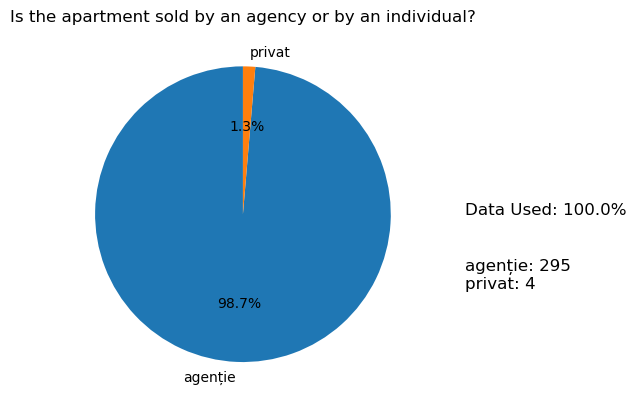

In [69]:
# Data to be analysed
data_used_percentage = (df['advertiser_type'].count() / len(df)) * 100
counts = df['advertiser_type'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
plt.pie(df['advertiser_type'].value_counts(), labels=df['advertiser_type'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Is the apartment sold by an agency or by an individual?')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

*building_material* Pie Chart

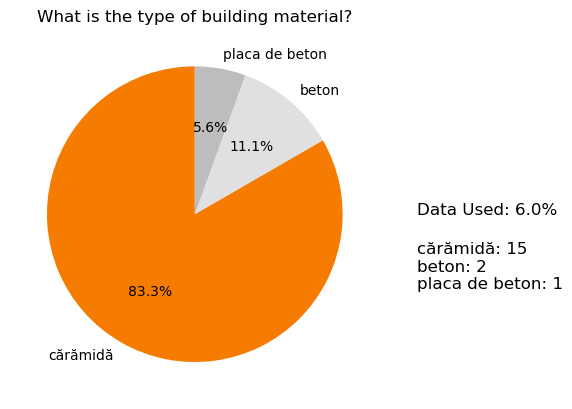

In [70]:
# Data to be analysed
data_used_percentage = (df['building_material'].count() / len(df)) * 100
counts = df['building_material'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
colors = ['#F57C00', '#E0E0E0', '#BDBDBD', '#9E9E9E']
plt.pie(df['building_material'].value_counts(), labels=df['building_material'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('What is the type of building material?')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

*building_ownership* Pie Chart

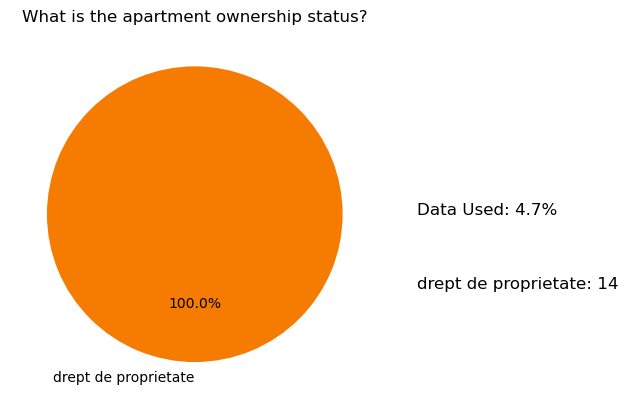

In [71]:
# Data to be analysed
data_used_percentage = (df['building_ownership'].count() / len(df)) * 100
counts = df['building_ownership'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
plt.pie(df['building_ownership'].value_counts(), labels=df['building_ownership'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('What is the apartment ownership status?')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

*building_type* Pie Chart

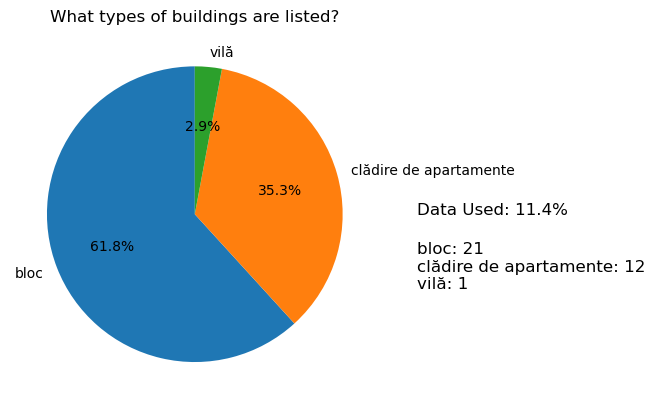

In [72]:
# Data to be analysed
data_used_percentage = (df['building_type'].count() / len(df)) * 100
counts = df['building_type'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
plt.pie(df['building_type'].value_counts(), labels=df['building_type'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('What types of buildings are listed?')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

*car* Pie Chart

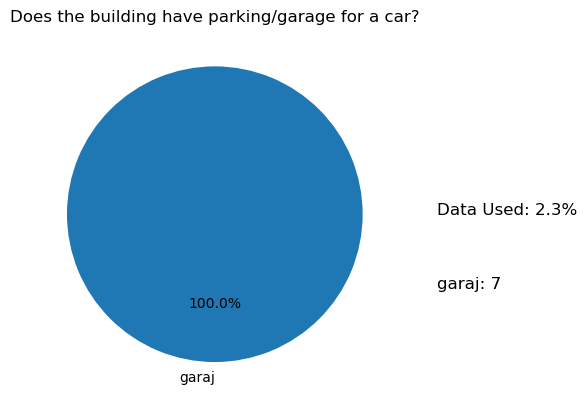

In [73]:
# Data to be analysed
data_used_percentage = (df['car'].count() / len(df)) * 100
counts = df['car'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
plt.pie(df['car'].value_counts(), labels=df['car'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title('Does the building have parking/garage for a car?')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

*construction_status* Pie Chart

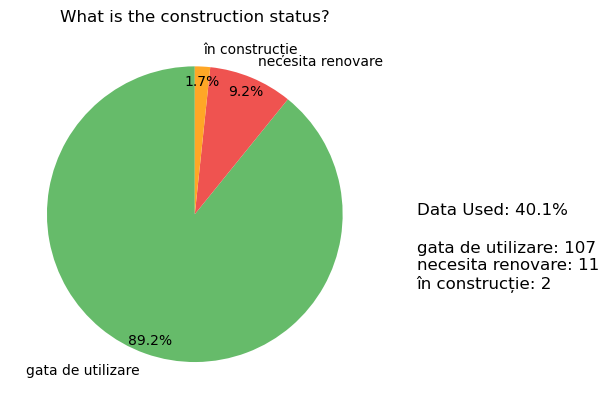

In [74]:
# Data to be analysed
data_used_percentage = (df['construction_status'].count() / len(df)) * 100
counts = df['construction_status'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
colors = ['#66BB6A', '#EF5350', '#FFA726']
plt.pie(df['construction_status'].value_counts(), labels=df['construction_status'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors, pctdistance=0.90, labeldistance=1.12)
plt.title('What is the construction status?')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

*heating* Pie Chart

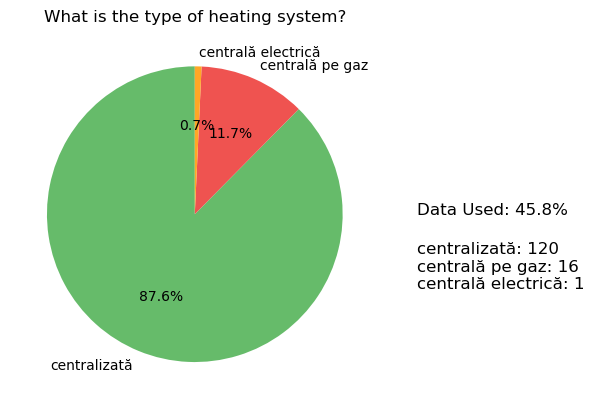

In [75]:
# Data to be analysed
data_used_percentage = (df['heating'].count() / len(df)) * 100
counts = df['heating'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
plt.pie(df['heating'].value_counts(), labels=df['heating'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('What is the type of heating system?')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

*lift* Pie Chart

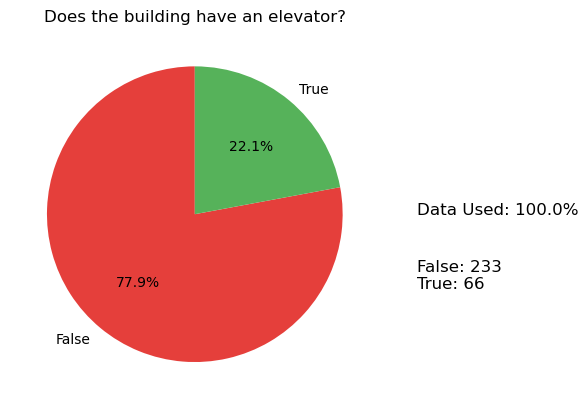

In [76]:
# Data to be analysed
data_used_percentage = (df['lift'].count() / len(df)) * 100
counts = df['lift'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
colors = ['#E53F3B', '#56B25A']
plt.pie(df['lift'].value_counts(), labels=df['lift'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Does the building have an elevator?')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

*market* Pie Chart

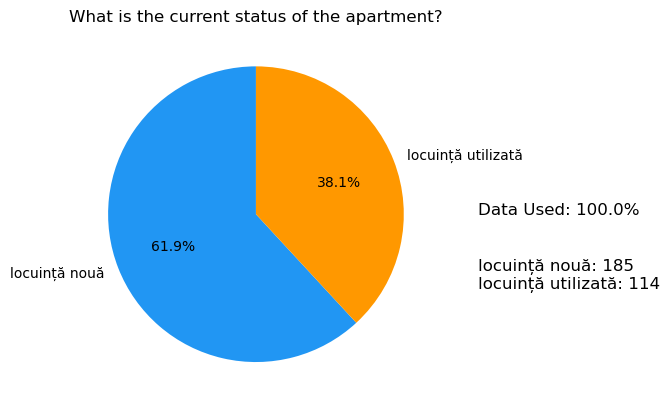

In [77]:
# Data to be analysed
data_used_percentage = (df['market'].count() / len(df)) * 100
counts = df['market'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
colors = ['#2196F3', '#FF9800']
plt.pie(df['market'].value_counts(), labels=df['market'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('What is the current status of the apartment?')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()

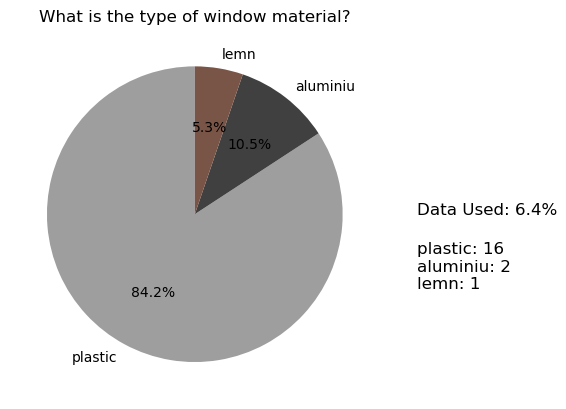

In [78]:
# Data to be analysed
data_used_percentage = (df['windows_type'].count() / len(df)) * 100
counts = df['windows_type'].value_counts().to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# To create a pie chart with additional text info
colors = ['#9E9E9E', '#404040', '#795548']
plt.pie(df['windows_type'].value_counts(), labels=df['windows_type'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('What is the type of window material?')
plt.text(1.5, 0, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(1.5, -0.5, multiline_text, color='black', fontsize=12)
plt.show()


Next, we are going to visualize a few columns as bar/histogram charts.

Columns: 'neighbourhood', 'price', 'rooms_num', 'build_year', 'floor'


*neighbourhood* Bar Chart <a id='popular_neighbourhoods_visualized'></a>

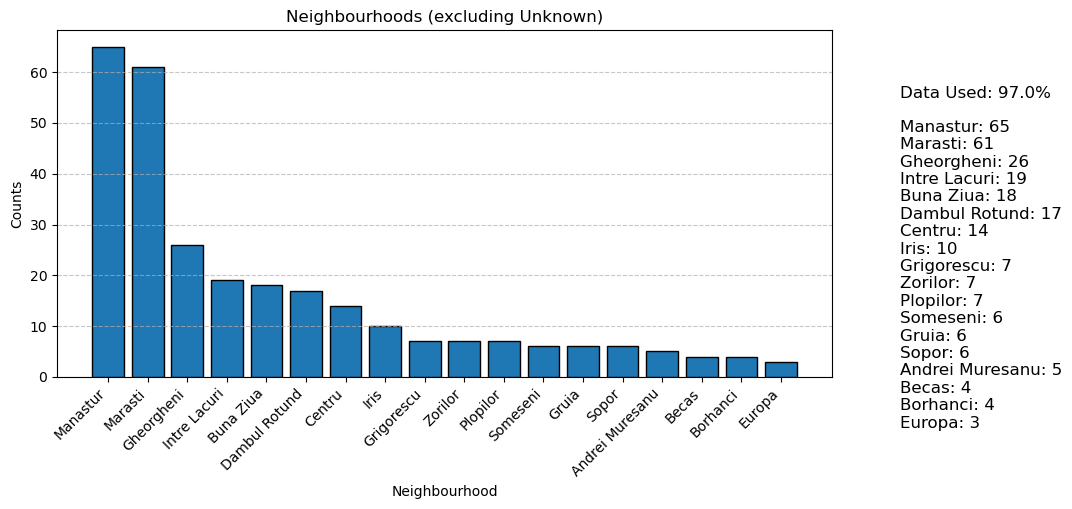

In [79]:
# Filter unknown neighbourhood
df['neighbourhood'] = df['neighbourhood'].fillna('Unknown')
filtered_df = df[df['neighbourhood'] != 'Unknown']

# Data to be analysed
data_used_percentage = (len(filtered_df)) / len(df) * 100
counts = filtered_df['neighbourhood'].value_counts().head(18).to_dict()
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# Create bar for the most popular 18 neighbourhoods
counts = filtered_df['neighbourhood'].value_counts().head(18)
plt.figure(figsize=(10, 4.5))
plt.bar(counts.index, counts, edgecolor='black')
plt.xlabel('Neighbourhood')
plt.ylabel('Counts')
plt.title('Neighbourhoods (excluding Unknown)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.text(20, 55, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.text(20, -10, multiline_text, color='black', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

*price* Histogram Chart

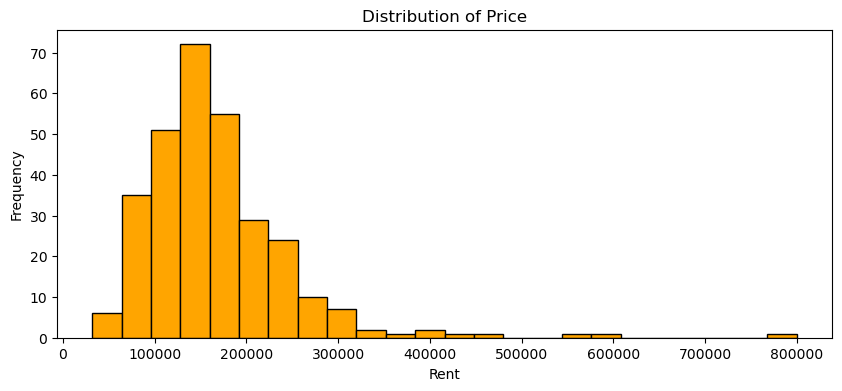

In [80]:
# Create hist chart
plt.figure(figsize=(10, 4))
plt.hist(df['price'], bins = 24, color='orange', edgecolor='black')
plt.xlabel('Rent')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

*rooms* Bar Chart

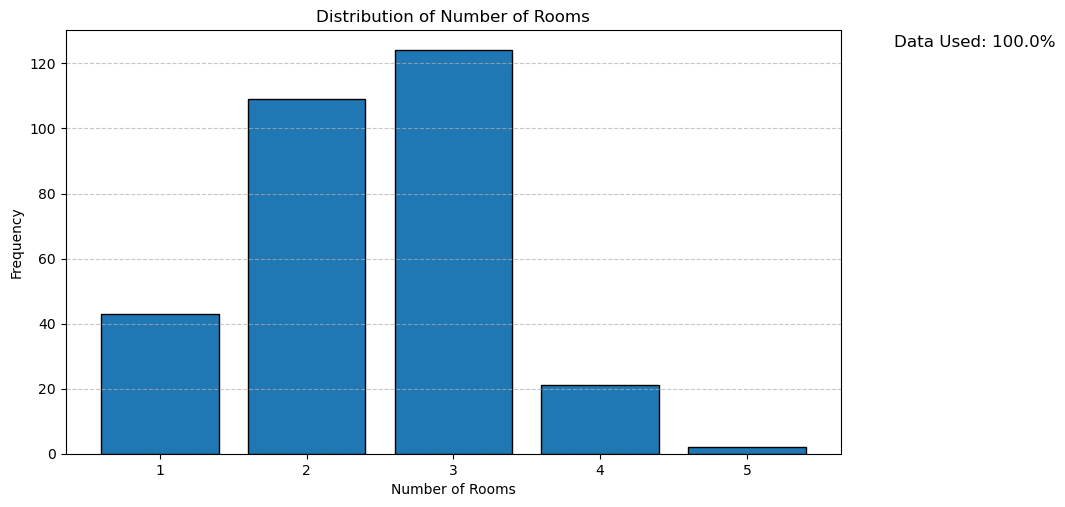

In [81]:
df['rooms_num'] = df['rooms_num'].fillna('Unknown')

# Filter data
filtered_df = df[df['rooms_num'] != 'Unknown']
filtered_df = filtered_df.sort_values(by='rooms_num')

# Data to be analysed
data_used_percentage = (len(filtered_df)) / len(df) * 100
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# Create bar chart
plt.figure(figsize=(10, 5.5))
counts = df['rooms_num'].value_counts()
plt.bar(counts.index, counts, edgecolor='black')
plt.xlabel('Number of Rooms')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.text(6, 125, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.title('Distribution of Number of Rooms')
plt.show()

*build_year* Histogram Chart  <a id='build_year_visualized1'></a>

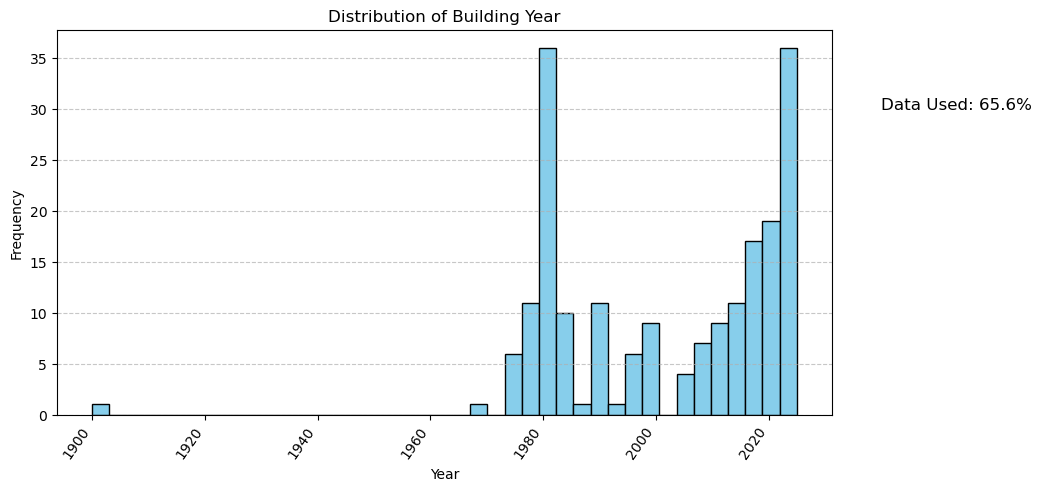

In [83]:
# Filter data
filtered_df = df[df['build_year'] != 0]
filtered_df = filtered_df.sort_values(by='build_year')

# Data to be analysed
data_used_percentage = (len(filtered_df)) / len(df) * 100
text_annotation = [f'{key}: {value}' for key, value in counts.items()]
multiline_text = '\n'.join(text_annotation)

# Create histogram
plt.figure(figsize=(10, 5))
plt.hist(filtered_df['build_year'], bins = filtered_df['build_year'].nunique(), color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.text(2040, 30, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.title('Distribution of Building Year')
plt.xticks(rotation=55, ha='right')
plt.show()

*floor* Bar Chart

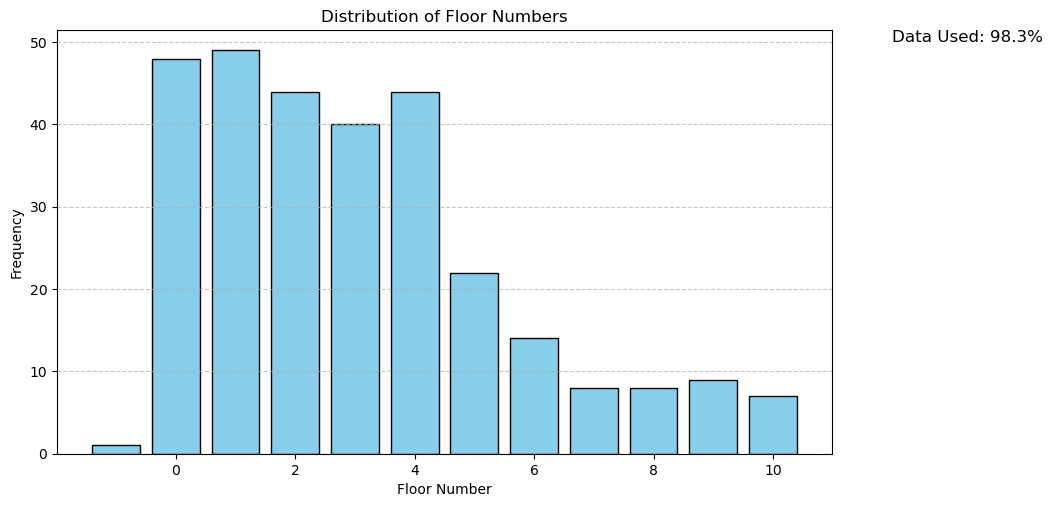

In [84]:
# Parse the data
temp_df = pd.DataFrame()
temp_df['floor_number'] = df['floor'].str.split('/').str[0]

# Convert 'floor_number' to numeric
temp_df['floor_number'] = pd.to_numeric(temp_df['floor_number'], errors='coerce')

# Data to be analyzed
data_used_percentage = (temp_df['floor_number'].count()) / len(df) * 100

# Create a bar chart
plt.figure(figsize=(10, 5.5))
floor_counts = temp_df['floor_number'].value_counts().sort_index()  # Sort by floor numbers
plt.bar(floor_counts.index, floor_counts, color='skyblue', edgecolor='black')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.text(12, 50, f'Data Used: {data_used_percentage:.1f}%', color='black', fontsize=12)
plt.xlabel('Floor Number')
plt.ylabel('Frequency')
plt.title('Distribution of Floor Numbers')
plt.show()

Next, we are going to combine a few columns as scatter charts.
Columns combined: 'area' & 'price', 

*area* & *price* Scatter Chart <a id='average_price_per_meter_vis'></a>

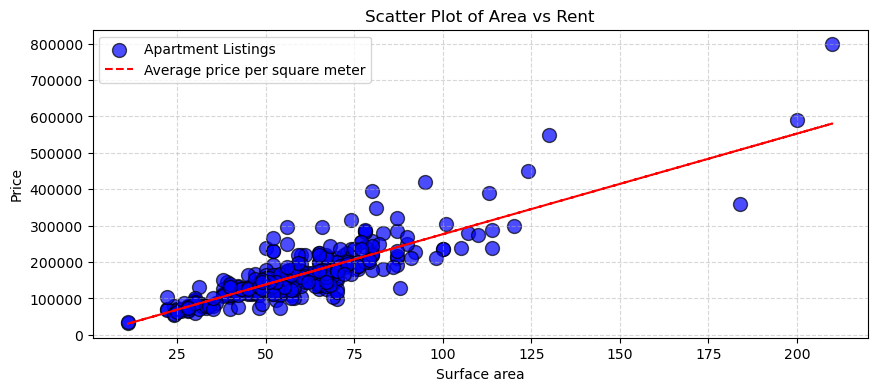

In [85]:
# Create scatter plot
plt.figure(figsize=(10, 4))
plt.scatter(df['area'], df['price'], alpha=0.7, s=100, c='blue', edgecolor='black', label='Apartment Listings')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Surface area')
plt.ylabel('Price')
plt.title('Scatter Plot of Area vs Rent')

# Remember how we found out the average price per meter square using numpy?
# We will use that variable here to crea a diagonal line, showcasing if listings prices are higher or lower than the average 
plt.plot(df['area'], df['area'] * average_price_per_square_meter, color='red', linestyle='--', label='Average price per square meter')

plt.legend()
plt.show()

*price* & *rooms_num* Scatter Chart <a id='average_price_per_room_vis'></a>

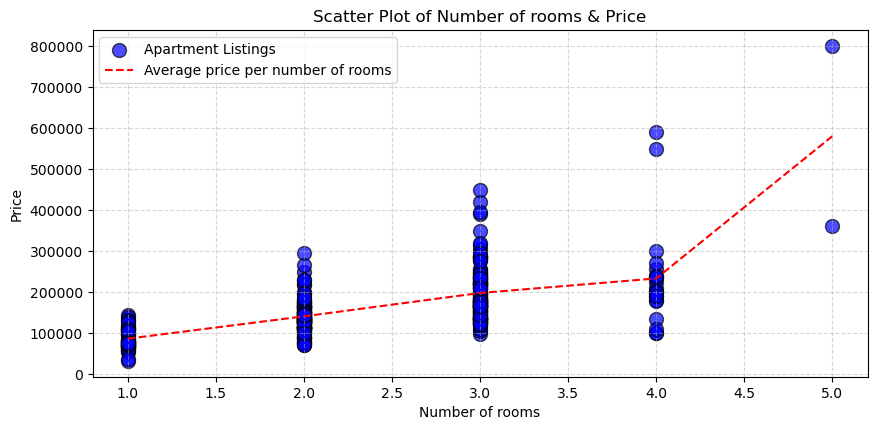

In [86]:
# Create scatter chart
plt.figure(figsize=(10, 4.5))
plt.scatter(df['rooms_num'], df['price'], alpha=0.7, s=100, c='blue', edgecolor='black', label='Apartment Listings')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Number of rooms')
plt.ylabel('Price')
plt.title('Scatter Plot of Number of rooms & Price')

# Remember how we used a function to calculate the average price for an apartment with x rooms?
# We will use that function here to showcase if an apartment is higher or lower that the average

# Values that will be used to construct the line
x_values = np.unique(df['rooms_num'])
y_values = [average_price_for_x_rooms(room) for room in x_values]

# To plot the line for average price per room
plt.plot(x_values, y_values, color='red', linestyle='--', label='Average price per number of rooms')

plt.legend()
plt.show()

*price* & *rooms_num* Scatter Chart <a id='build_year_visualized2'></a>

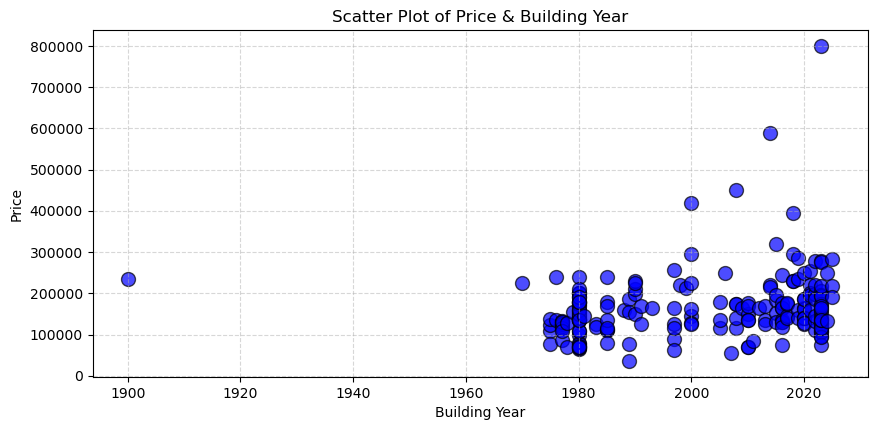

In [87]:
# Filter data
filtered_df = df[df['build_year'] != 0]
filtered_df = filtered_df.sort_values(by='build_year')

plt.figure(figsize=(10, 4.5))
plt.scatter(filtered_df['build_year'], filtered_df['price'], alpha=0.7, s=100, c='blue', edgecolor='black', label='Data Points')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Building Year')
plt.ylabel('Price')
plt.title('Scatter Plot of Price & Building Year')
plt.show()

**FIN**

Key Insights and Impact:

   Through this project, I found out about crucial insights into the real estate landscape. Some key findings include:

   Price per Square Meter: The average price per square meter, calculated [here](#average_price_per_meter_calc), visualized [here](#average_price_per_meter_vis), offers a nuanced perspective on property value and market competitiveness.

Average Price per Room Analysis: The average apartment price per room, calculated [here](#average_price_per_room_calc) and visualized [here](#average_price_per_room_vis)

   Neighborhood Dynamics: By visualizing and analyzing popular neighborhoods, gained insights into the distribution of listings and identified areas of high demand, visualized [here](#popular_neighbourhoods_visualized) and calculated [here](#popular_neighbourhoods_calc).

   Building Year Impact: Understanding the distribution of building years, offering valuable information for those interested in the age of properties, visualized [here](#build_year_visualized1) and [here](#build_year_visualized2).